# Single Species Files

We demonstrate the classification of bird species observed in the Mt Kenya ecosystem leveraging open source models. In particular we demonstrate the use of embeddings obtained from Google's [Bird Vocalization Classifier](https://www.kaggle.com/models/google/bird-vocalization-classifier) to train classifiers for the species observed.

In this notebook we process the annotation data to determine files containing single species.

In [1]:
import os
import random
import librosa
import scipy 
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scipy import stats
from matplotlib_venn import venn2

In [2]:
def species_from_df(df):
    sps = []
    for i in range(len(df)):
        if not pd.isna(df.iloc[i]['Foreground Species']):
            sps += df.iloc[i]['Foreground Species'].split(';')
        if not pd.isna(df.iloc[i]['Background Species']):
            sps += df.iloc[i]['Background Species'].split(';')
    return list(set(sps))


In [3]:
# get all species
mknp_aru = pd.read_csv('../annotations/mknp-aru-2017-2018.csv')
mknp_aru_species = species_from_df(mknp_aru)

dekuwc_aru_2016 = pd.read_csv('../annotations/dekuwc-aru-2016.csv')
dekuwc_aru_2017 = pd.read_csv('../annotations/dekuwc-aru-2017.csv')

dekuwc_aru = pd.concat([dekuwc_aru_2016, dekuwc_aru_2017])
dekuwc_aru_species = species_from_df(dekuwc_aru)

mknp_dekuwc_aru = pd.concat([mknp_aru, dekuwc_aru])

In [4]:
mknp_dekuwc_aru

,Filename,Foreground Species,Background Species,Remarks
0,MKNP-1-2017-11-20-07-15-12.mp3,White-starred Robin,Olive Sunbird,NaN
1,MKNP-1-2017-11-20-08-45-12.mp3,White-starred Robin;Brown Woodland Warbler,NaN,NaN
2,MKNP-1-2017-11-20-09-30-12.mp3,Cinnamon Bracken Warbler,NaN,NaN
3,MKNP-1-2017-11-20-10-45-12.mp3,NaN,Brown Woodland Warbler,NaN
4,MKNP-1-2017-11-21-07-10-13.mp3,NaN,Brown Woodland Warbler,NaN
...,...,...,...,...
295,DeKUWC-10-2017-02-16-08-11-09.mp3,Tropical Boubou;Brown-backed Scrub Robin;Thrus...,Olive Thrush;Emerald-spotted Wood Dove;Yellow-...,NaN
296,DeKUWC-10-2017-02-16-08-51-17.mp3,Olive Thrush;Yellow-whiskered Greenbul,Cinnamon-chested Bee-eater,NaN
297,DeKUWC-10-2017-02-16-09-16-22.mp3,Yellow-rumped Tinkerbird,Yellow-rumped Tinkerbird;Grey-backed Camaroptera,NaN
298,DeKUWC-10-2017-02-16-09-31-25.mp3,Yellow-rumped Tinkerbird;Grey-backed Camaroptera,NaN,NaN


## Species Overlap

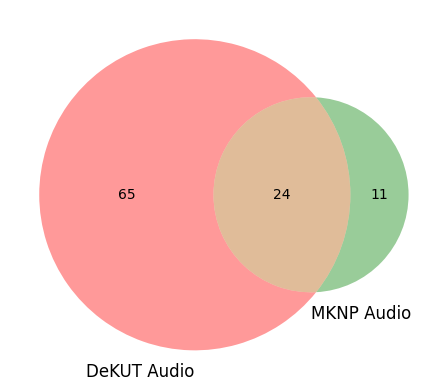

In [5]:
venn2((set(dekuwc_aru_species), set(mknp_aru_species)), 
      set_labels = ('DeKUT Audio', 'MKNP Audio'))

## Data for model training
We use audio data which contains a single species either in the background or foreground to train single species identification classifier

In [6]:
single_species = []
single_species_filenames = {}
for i in range(len(mknp_dekuwc_aru)):
    if not pd.isna(mknp_dekuwc_aru.iloc[i]['Foreground Species']) and pd.isna(mknp_dekuwc_aru.iloc[i]['Background Species']):
        sps = mknp_dekuwc_aru.iloc[i]['Foreground Species'].split(';')
        if len(sps) == 1:
            single_species += sps
            single_species_filenames[mknp_dekuwc_aru.iloc[i]['Filename']] = sps[0]
    if not pd.isna(mknp_dekuwc_aru.iloc[i]['Background Species']) and pd.isna(mknp_dekuwc_aru.iloc[i]['Foreground Species']):
        sps = mknp_dekuwc_aru.iloc[i]['Background Species'].split(';')
        if len(sps) == 1:
            single_species += sps
            single_species_filenames[mknp_dekuwc_aru.iloc[i]['Filename']] = sps[0]

## Species distribution of single species recordings

In [7]:
Counter(single_species)

Counter({'Brown Woodland Warbler': 225,
         'Chestnut-throated Apalis': 26,
         'Yellow-whiskered Greenbul': 24,
         'White-starred Robin': 16,
         'Red-fronted Parrot': 16,
         'Cinnamon Bracken Warbler': 14,
         'Mountain Yellow Warbler': 14,
         'Montane White-eye': 12,
         "Hartlaub's Turaco": 12,
         'Grey-backed Camaroptera': 9,
         'Common Bulbul': 9,
         'Crowned Eagle': 6,
         'Cinnamon-chested Bee-eater': 4,
         'Grey Apalis': 3,
         'Olive Sunbird': 3,
         'Yellow-rumped Tinkerbird': 3,
         'Red-fronted Tinkerbird': 3,
         'Cape Robin Chat': 3,
         'Montane Oriole': 3,
         'Tropical Boubou': 2,
         'Silvery-cheeked Hornbill': 2,
         'Collared Sunbird': 2,
         'African Dusky Flycatcher': 1,
         'Mountain Greenbul': 1,
         'Grey-capped Warbler': 1,
         'African Paradise Flycatcher': 1,
         'Narina Trogon': 1,
         "Cabanis's Greenbul": 1,
      

In [8]:
with open('../annotations/single_species_filenames.json', 'w') as fp:
    json.dump(single_species_filenames, fp)